<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/FuzzyModelingAndAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed
Epoch 1/50
14/14 [==============================] - 6s 67ms/step - loss: 0.1209
Epoch 2/50
14/14 [==============================] - 1s 67ms/step - loss: 0.0095
Epoch 3/50
14/14 [==============================] - 1s 66ms/step - loss: 0.0047
Epoch 4/50
14/14 [==============================] - 1s 65ms/step - loss: 0.0031
Epoch 5/50
14/14 [==============================] - 1s 65ms/step - loss: 0.0024
Epoch 6/50
14/14 [==============================] - 1s 65ms/step - loss: 0.0020
Epoch 7/50
14/14 [==============================] - 1s 68ms/step - loss: 0.0019
Epoch 8/50
14/14 [==============================] - 1s 66ms/step - loss: 0.0019
Epoch 9/50
14/14 [==============================] - 1s 98ms/step - loss: 0.0018
Epoch 10/50
14/14 [==============================] - 1s 102ms/step - loss: 0.0018
Epoch 11/50
14/14 [==============================] - 1s 73ms/step - loss: 0.0018
Epoch 12/50
14/14 [=============================

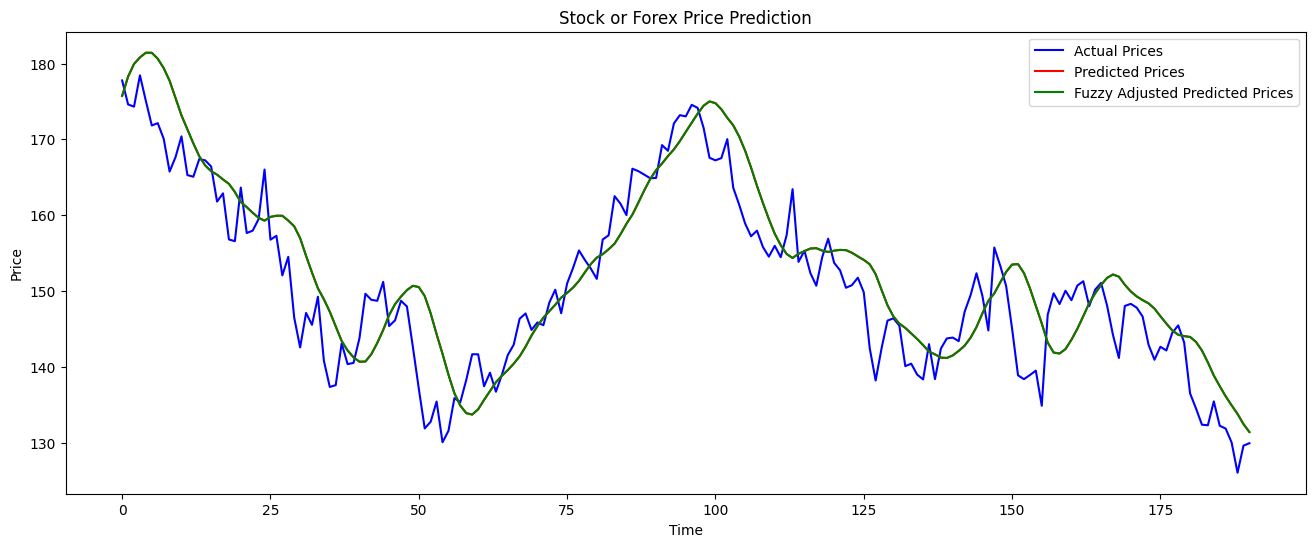

6/6 [==============================] - 0s 27ms/step
Hold


In [14]:
# 1. Libraries
!pip install scikit-fuzzy
!pip install yfinance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
# 2. Data Loading and Preprocessing
import yfinance as yf
import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# Fetch data from Yahoo Finance
symbol = 'AAPL' # For Apple
data = yf.download(symbol, start="2020-01-01", end="2022-01-01")

# Use the 'Close' prices
closing_prices = data['Close'].values

# Assume 'Close' column contains the closing prices
closing_prices = data['Close'].values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

# 3. Creating Training Dataset

look_back = 60 # How many past days we want to use to predict the next value
X, y = [], []
for i in range(look_back, len(scaled_data)):
    X.append(scaled_data[i-look_back:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# 4. Neural Network Model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=50, batch_size=32)

# 5. Predictions

test_data = yf.download(symbol, start="2022-01-01", end="2022-12-31")
actual_prices = test_data['Close'].values
scaled_test_data = scaler.transform(actual_prices.reshape(-1, 1))

X_test = []
for i in range(look_back, len(scaled_test_data)):
    X_test.append(scaled_test_data[i-look_back:i, 0])
X_test = np.array(X_test)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# 6. Fuzzy Logic Adjustment
# Assuming fuzzy logic might adjust predictions based on some other rules or variables.
def fuzzy_adjust(predictions):
   predictions = predictions.flatten()  # Ensure it's a 1D array

   # Define fuzzy membership functions
   low = fuzz.trimf(predictions, [0, 0, 0.5])
   medium = fuzz.trimf(predictions, [0, 0.5, 1])
   high = fuzz.trimf(predictions, [0.5, 1, 1])

   # Apply some fuzzy logic rule for illustration purposes
   adjusted_predictions = predictions.copy()
   adjusted_predictions[low > 0.5] *= 0.95
   adjusted_predictions[high > 0.5] *= 1.05

   return adjusted_predictions

# This is just a hypothetical function and would need to be properly implemented.
#fuzzy_adjusted_predictions = fuzz.fuzzy_adjust(predictions)
fuzzy_adjusted_predictions = fuzzy_adjust(predictions)

# 7. Visualization

plt.figure(figsize=(16, 6))
plt.plot(actual_prices[look_back:], color='blue', label="Actual Prices")
plt.plot(predictions, color='red', label="Predicted Prices")
plt.plot(fuzzy_adjusted_predictions, color='green', label="Fuzzy Adjusted Predicted Prices")
plt.title('Stock or Forex Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# ... (the rest of the code for LSTM model)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
predictions = predictions.flatten()

# Compute Price Trend and Prediction Error
trend = np.sign(np.diff(closing_prices[-len(predictions):]))
#error = np.sign(predictions.flatten() - closing_prices[-len(predictions)+1:])
error = np.sign(predictions.flatten() - closing_prices[-len(predictions):])


# Define fuzzy membership functions for Trend
trend_lo = fuzz.trimf(trend, [-1, -1, 0])
trend_md = fuzz.trimf(trend, [-1, 0, 1])
trend_hi = fuzz.trimf(trend, [0, 1, 1])

# Define fuzzy membership functions for Error
error_lo = fuzz.trimf(error, [-1, -1, 0])
error_md = fuzz.trimf(error, [-1, 0, 1])
error_hi = fuzz.trimf(error, [0, 1, 1])


if trend_hi.shape[0] > error_lo.shape[0]:
    trend_hi = trend_hi[:-1]
elif error_lo.shape[0] > trend_hi.shape[0]:
    error_lo = error_lo[:-1]

if trend_lo.shape[0] > error_hi.shape[0]:
    trend_lo = trend_lo[:-1]
elif error_hi.shape[0] > trend_lo.shape[0]:
    error_hi = error_hi[:-1]


# Define fuzzy membership functions for Action
action_range = np.linspace(-1, 1, num=len(trend))
action_buy = fuzz.trimf(action_range, [0, 1, 1])
action_hold = fuzz.trimf(action_range, [-1, 0, 1])
action_sell = fuzz.trimf(action_range, [-1, -1, 0])

# Evaluate fuzzy rules
rule1 = np.fmin(trend_hi, error_lo)
act_buy = np.fmin(rule1, action_buy)

rule2 = np.fmin(trend_lo, error_hi)
act_sell = np.fmin(rule2, action_sell)

rule3a = trend_md
rule3b = error_md

if rule3a.shape[0] > action_hold.shape[0]:
    rule3a = rule3a[:-1]
elif action_hold.shape[0] > rule3a.shape[0]:
    action_hold = action_hold[:-1]

if rule3b.shape[0] > action_hold.shape[0]:
    rule3b = rule3b[:-1]
elif action_hold.shape[0] > rule3b.shape[0]:
    action_hold = action_hold[:-1]

act_hold = np.fmax(np.fmin(rule3a, action_hold), np.fmin(rule3b, action_hold))

# Aggregate all the rules for decision
aggregated = np.fmax(act_buy, np.fmax(act_hold, act_sell))

# Compute the decision using defuzzification
decision = fuzz.defuzz(action_range, aggregated, 'centroid')
decision_activation = fuzz.interp_membership(action_range, aggregated, decision)

# Interpret the decision for next 5 days
if decision > 0.5:
    print("Buy")
elif decision < -0.5:
    print("Sell")
else:
    print("Hold")